In [3]:
import torch
import torchvision
import os
import glob
import time
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from unet_sgd.src.data import LungDataset, blend, Pad, Crop, Resize
from unet_sgd.src.models import UNet, PretrainedUNet
from unet_sgd.src.metrics import jaccard, dice

ModuleNotFoundError: No module named 'unet_sgd'

In [7]:
!ls /kaggle/input/unet-sgd/
!ls /kaggle/input/unet-sgd/src/src


input  models  src
data.py  metrics.py  models.py


In [35]:
import sys
sys.path.append('/kaggle/input/unet-sgd/')


In [89]:
import torch
import torchvision
import os
import glob
import time
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.src.data import LungDataset, blend, Pad, Crop, Resize
from src.src.models import UNet, PretrainedUNet
from src.src.metrics import jaccard, dice

In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [91]:
!ls /kaggle/input/
!ls /kaggle/input/unet-sgd/
!ls /kaggle/input/unet-sgd/input
!ls /kaggle/input/unet-sgd/input/input


unet-sgd
images	input  models  src
input
dataset


In [92]:
from pathlib import Path

In [93]:

# Construct the correct path to the dataset and models
data_folder = Path("/kaggle/input/unet-sgd/input/input/dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"
models_folder = Path("/kaggle/input/unet-sgd/models")
images_folder = Path("/kaggle/input/unet-sgd/images/images")  # Assuming images will be saved in the working directory

# Verify if the paths exist
print("Origins folder exists:", origins_folder.exists())  # Should print True
print("Masks folder exists:", masks_folder.exists())    # Should print True
print("Models folder exists:", models_folder.exists())  # Should print True

# List files in directories to ensure correctness
print("Files in origins folder:", list(origins_folder.glob("*.png")))
print("Files in masks folder:", list(masks_folder.glob("*.png")))
print("Files in models folder:", list(models_folder.glob("*")))

Origins folder exists: True
Masks folder exists: True
Models folder exists: True
Files in origins folder: [PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/CHNCXR_0092_0.png'), PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/CHNCXR_0322_0.png'), PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/CHNCXR_0304_0.png'), PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/CHNCXR_0572_1.png'), PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/CHNCXR_0547_1.png'), PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/CHNCXR_0629_1.png'), PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/CHNCXR_0618_1.png'), PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/CHNCXR_0242_0.png'), PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/MCUCXR_0017_0.png'), PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/CHNCXR_0041_0.png'), PosixPath('/kaggle/input/unet-sgd/input/input/dataset/images/CHNCXR_0410_

In [94]:
# Create lists of filenames
origins_list = [f.stem for f in origins_folder.glob("*.png")]
masks_list = [f.stem for f in masks_folder.glob("*.png")]


In [95]:
print("Number of origin images:", len(origins_list))  # Should print the number of .png files in the images folder
print("Number of mask images:", len(masks_list))      # Should print the number of .

Number of origin images: 800
Number of mask images: 704


In [96]:
batch_size = 4

## Data loading

In [97]:
origins_list = [f.stem for f in origins_folder.glob("*.png")]
masks_list = [f.stem for f in masks_folder.glob("*.png")]

In [98]:
print(len(origins_list))
print(len(masks_list))

800
704


In [99]:
origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]

In [100]:
split_file = "splits.pk"
if os.path.isfile(split_file):
    with open("splits.pk", "rb") as f:
        splits = pickle.load(f)
else:
    splits = {}
    splits["train"], splits["test"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
    splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

    with open("splits.pk", "wb") as f:
        pickle.dump(splits, f)

In [101]:
val_test_transforms = torchvision.transforms.Compose([
    Resize((512, 512)),
])

train_transforms = torchvision.transforms.Compose([
    Pad(200),
    Crop(300),
    val_test_transforms,
])

datasets = {x: LungDataset(
    splits[x],
    origins_folder,
    masks_folder,
    train_transforms if x == "train" else val_test_transforms
) for x in ["train", "test", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size) for x in ["train", "test", "val"]}

In [68]:
!pip install opencv-python

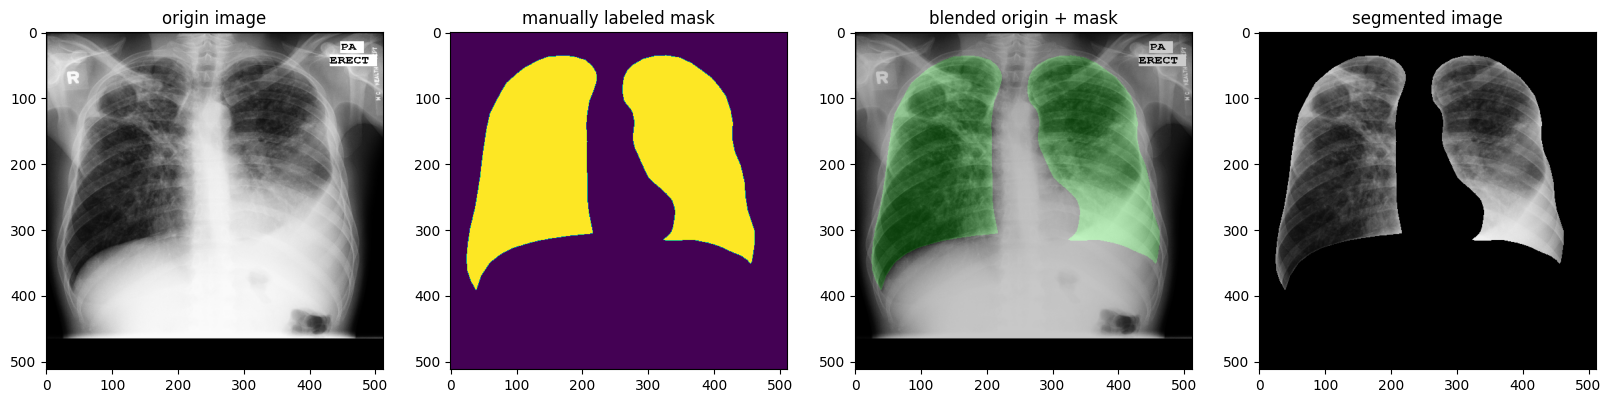

In [103]:
import cv2
def blend_with_mask(image, mask):
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    segmented_image = cv2.bitwise_and(image, mask)

    return segmented_image
idx = 0
phase = "train"

plt.figure(figsize=(20, 10))
origin, mask = datasets[phase][idx]

pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
pil_mask = torchvision.transforms.functional.to_pil_image(mask.float())

plt.subplot(1, 4, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 4, 2)
plt.title("manually labeled mask")
plt.imshow(np.array(pil_mask))

plt.subplot(1, 4, 3)
plt.title("blended origin + mask")
plt.imshow(np.array(blend(origin, mask)));

segmented_image = blend_with_mask(np.array(pil_origin), np.array(pil_mask))

plt.subplot(1, 4, 4)
plt.title("segmented image")
plt.imshow(segmented_image);

plt.savefig("/kaggle/working/data-example.png", bbox_inches='tight')


## Model training

In [104]:
# unet = UNet(in_channels=1, out_channels=2, batch_norm=True)
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)
unet

PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

In [105]:
unet = unet.to(device)
optimizer = torch.optim.SGD(unet.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(unet.parameters(), lr=0.0005)

In [106]:
train_log_filename = "train-log.txt"
epochs = 100
best_val_loss = np.inf
model_name = "unet-6v.pt"

In [ ]:
hist = []

for e in range(epochs):
    start_t = time.time()

    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in dataloaders["train"]:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        loss = torch.nn.functional.nll_loss(softmax, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * num
        print(".", end="")

    train_loss = train_loss / len(datasets['train'])
    print()


    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in dataloaders["val"]:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outs = unet(origins)
            softmax = torch.nn.functional.log_softmax(outs, dim=1)
            val_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

            outs = torch.argmax(softmax, dim=1)
            outs = outs.float()
            masks = masks.float()
            val_jaccard += jaccard(masks, outs.float()).item() * num
            val_dice += dice(masks, outs).item() * num

        print(".", end="")
    val_loss = val_loss / len(datasets["val"])
    val_jaccard = val_jaccard / len(datasets["val"])
    val_dice = val_dice / len(datasets["val"])
    print()


    end_t = time.time()
    spended_t = end_t - start_t

    with open(train_log_filename, "a") as train_log_file:
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
               + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)
        train_log_file.write(report + "\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), "/kaggle/working/unet-6v.pt")
            print("model saved")
            train_log_file.write("model saved\n")
        print()


train phase
...............................................................................................................................
validation phase
...............
epoch: 1/100, time: 177.5516538619995, train loss: 0.22654302491854303, 
val loss: 0.1508305323751349, val jaccard: 0.8543463945388794, val dice: 0.9203544792376066
model saved

train phase
...............................................................................................................................
validation phase
...............
epoch: 2/100, time: 177.13894510269165, train loss: 0.11852147412512143, 
val loss: 0.08463443266718011, val jaccard: 0.913325309753418, val dice: 0.9542483687400818
model saved

train phase
...............................................................................................................................
validation phase
...............
epoch: 3/100, time: 177.48368573188782, train loss: 0.0895423077547503, 
val loss: 0.07266888427629806, val jaccard: 0.91971

epochs: 100, overall time: 208.0m, mean epoch time: 125.39527705907821s


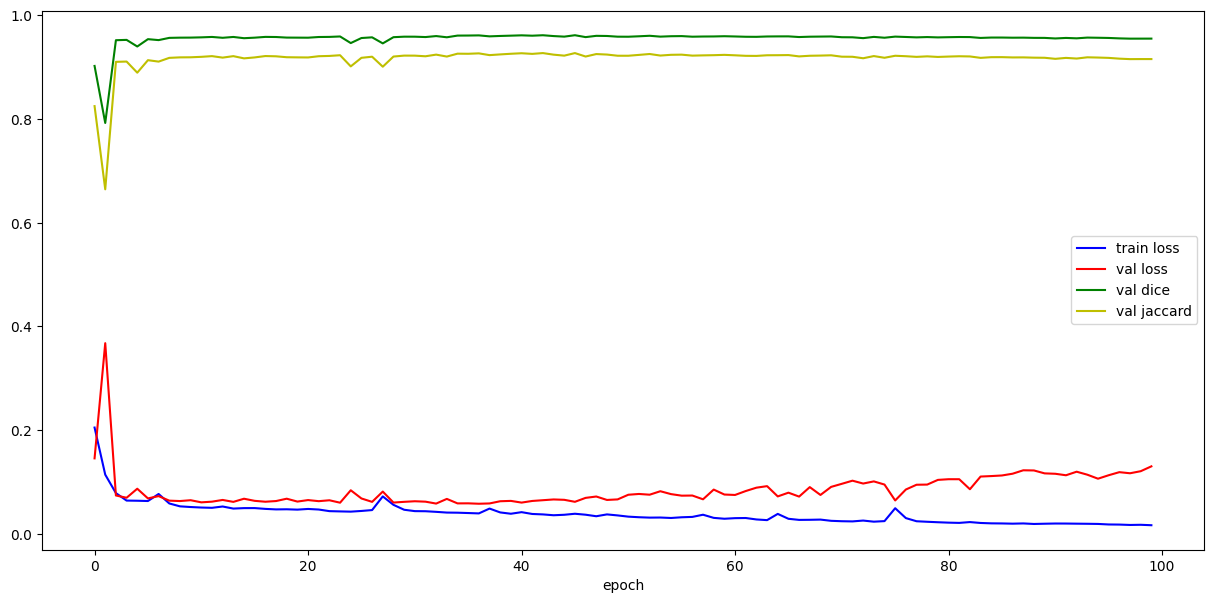

In [ ]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

In [ ]:
torch.cuda.empty_cache()

## Evaluate

In [ ]:
unet = PretrainedUNet(1, 2, True, "bilinear")

In [ ]:
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [ ]:
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        test_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

        outs = torch.argmax(softmax, dim=1)
        outs = outs.float()
        masks = masks.float()
        test_jaccard += jaccard(masks, outs).item() * num
        test_dice += dice(masks, outs).item() * num
    print(".", end="")

test_loss = test_loss / len(datasets["test"])
test_jaccard = test_jaccard / len(datasets["test"])
test_dice = test_dice / len(datasets["test"])

print()
print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

....................................

avg test loss: 0.06104250159775112

avg test jaccard: 0.9264533802972618

avg test dice: 0.9609397590583098


.........

red area - predict(mask made by unet)

green area - ground truth(mask made by radiologist)

yellow area - intersection(common bw predicted and original mask)


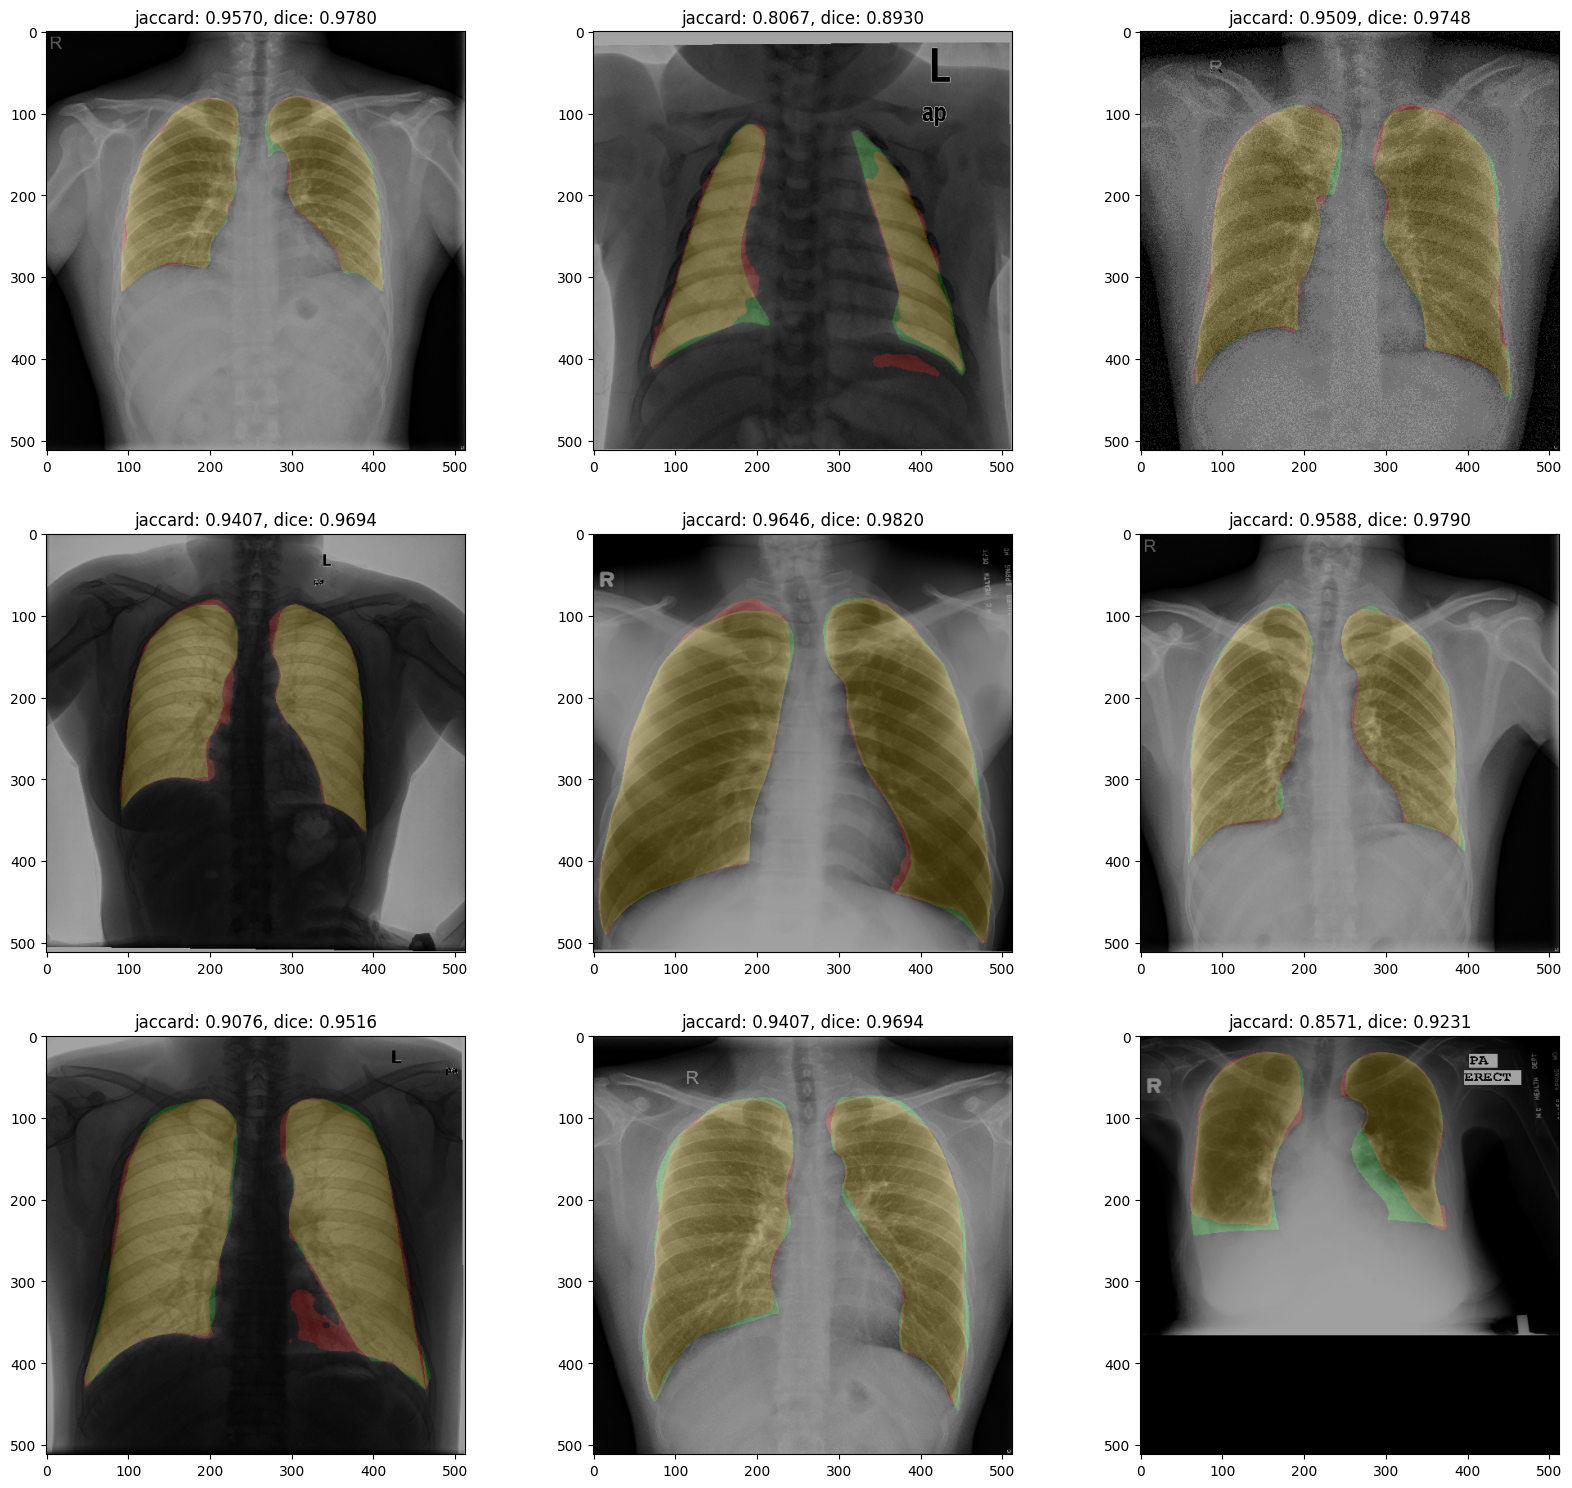

In [ ]:
num_samples = 9
phase = "test"

subset = torch.utils.data.Subset(
    datasets[phase],
    np.random.randint(0, len(datasets[phase]), num_samples)
)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)
plt.figure(figsize=(20, 25))

for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx+1)

    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        jaccard_score = jaccard(mask.float(), out.float()).item()
        dice_score = dice(mask.float(), out.float()).item()

        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        mask = mask[0].to("cpu")

        plt.imshow(np.array(blend(origin, mask, out)))
        plt.title(f"jaccard: {jaccard_score:.4f}, dice: {dice_score:.4f}")
        print(".", end="")

plt.savefig(images_folder / "obtained-results.png", bbox_inches='tight')
print()
print("red area - predict(mask made by unet)")
print("green area - ground truth(mask made by radiologist)")
print("yellow area - intersection(common bw predicted and original mask)")

## Inference


In [ ]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)

In [ ]:
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
origin = Image.open(origin_filename).convert("P")
origin = torchvision.transforms.functional.resize(origin, (512, 512))
origin = torchvision.transforms.functional.to_tensor(origin) - 0.5


In [ ]:
with torch.no_grad():
    origin = torch.stack([origin])
    origin = origin.to(device)
    out = unet(origin)
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)

    origin = origin[0].to("cpu")
    out = out[0].to("cpu")

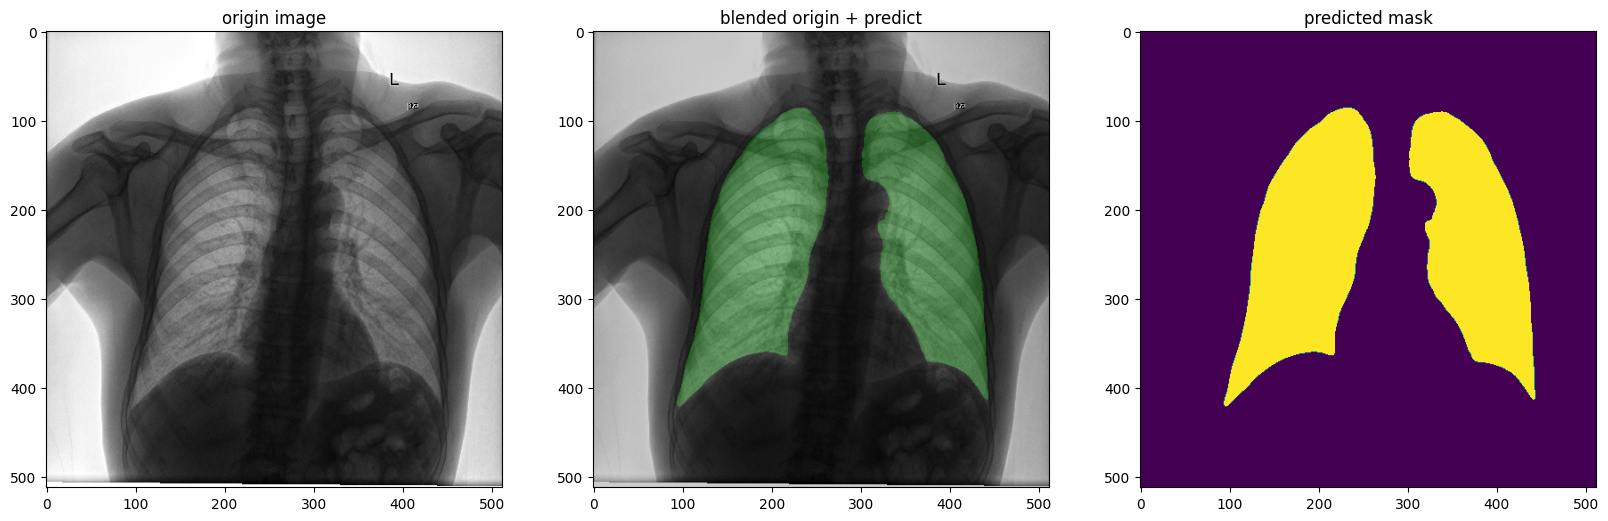

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
#mask = torchvision.transforms.functional.to_pil_image(mask.float())


plt.subplot(1, 3, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 3, 2)
plt.title("blended origin + predict")
plt.imshow(np.array(blend(origin, out)));

plt.subplot(1, 3, 3)
plt.title("predicted mask")
plt.imshow(np.array( out));



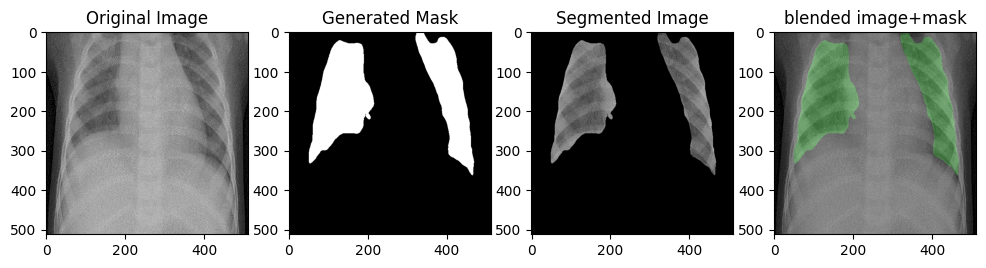

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the blending function
def blend_with_mask(image, mask):
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    segmented_image = cv2.bitwise_and(image, mask)
    return segmented_image

# Load the image
image_path = Path("pneumonia/person1_bacteria_1.jpeg")
origin = Image.open(image_path).convert("P")
origin = torchvision.transforms.functional.resize(origin, (512, 512))
origin = torchvision.transforms.functional.to_tensor(origin) - 0.5

# Prepare input tensor and move to device
with torch.no_grad():
    origin = torch.stack([origin])
    origin = origin.to(device)
    out = unet(origin)
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)

# Move tensors back to CPU
origin = origin[0].to("cpu")
out = out[0].to("cpu")

# Convert tensors to PIL images
pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
pil_mask = torchvision.transforms.functional.to_pil_image(out.float())

# Save mask
mask_path = Path("pneumonia")
pil_mask.save(os.path.join(mask_path, f"{os.path.basename(image_path)}_mask.jpg"))

# Convert PIL images to NumPy arrays for blending
image_array = np.array(pil_origin)
mask_array = np.array(pil_mask)

# Blend the image and mask
segmented_image = blend_with_mask(image_array, mask_array)

# Save segmented image
segmented_image_path =Path("pneumonia")
# Save segmented image with higher quality
# Save segmented image in PNG format
cv2.imwrite(os.path.join(segmented_image_path, f"{os.path.basename(image_path)}_segmented.png"), cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))

# Plot the mask and segmented image
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(image_array)

plt.subplot(1, 4, 2)
plt.title("Generated Mask")
plt.imshow(mask_array, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Segmented Image")
plt.imshow(segmented_image)

plt.subplot(1, 4, 4)
plt.title("blended image+mask")
plt.imshow(np.array(blend(origin,out)))

plt.show()


# Making Masks of the Dataset

In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms.functional
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import glob
import time
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice

In [ ]:
data_folder = Path("input", "dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"
models_folder = Path("models")
images_folder = Path("images")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
unet = PretrainedUNet(1, 2, True, "bilinear")
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval()

C:\Users\bhagirathi\miniconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

C:\Users\bhagirathi\miniconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms.functional
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import os
import numpy as np
import torch
import torchvision.transforms.functional
from PIL import Image
import os
import numpy as np
import torch
import torchvision.transforms.functional as TF
from PIL import Image

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths for the new dataset
montgomery_normal_folder = r"D:\tb_dataset\archive (3)\Dataset\Montgomery\Normal"
montgomery_tb_folder = r"D:\tb_dataset\archive (3)\Dataset\Montgomery\TB"
schzen_normal_folder = r"D:\tb_dataset\archive (3)\Dataset\Schenzen\Normal"
schzen_tb_folder = r"D:\tb_dataset\archive (3)\Dataset\Schenzen\TB"

# Create output folder for segmented images and masks
output_folder = r"D:\tb_dataset\Dataset_Segmented"
os.makedirs(output_folder, exist_ok=True)
output_normal_folder = os.path.join(output_folder, "Normal")
output_tb_folder = os.path.join(output_folder, "TB")
os.makedirs(output_normal_folder, exist_ok=True)
os.makedirs(output_tb_folder, exist_ok=True)

# Load pretrained U-Net model
unet = PretrainedUNet(1, 2, True, "bilinear")
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval()

def blend_with_mask(image, mask):
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    segmented_image = cv2.bitwise_and(image, mask)
    return segmented_image

# Function to apply U-Net on an image and save segmented image and mask
def apply_unet_on_image(image_path, output_path):
    origin = Image.open(image_path).convert("L")  # Convert to grayscale
    origin = TF.resize(origin, (512, 512))
    origin_tensor = TF.to_tensor(origin).unsqueeze(0) - 0.5  # Add batch dimension and normalize
    with torch.no_grad():
        origin_tensor = origin_tensor.to(device)
        out = unet(origin_tensor)
        _, predicted = torch.max(out, 1)  # Get the index of the max log-probability
        predicted = predicted.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
        predicted = (predicted * 255).astype(np.uint8)  # Convert to uint8 (0-255)

        # Convert origin tensor back to numpy array
        origin_array = TF.to_pil_image(origin_tensor.squeeze() + 0.5).convert("RGB")
        origin_array = np.array(origin_array)

        # Convert predicted mask to BGR format
        mask = cv2.cvtColor(predicted, cv2.COLOR_GRAY2BGR)

        # Apply bitwise_and operation
        segmented_image = cv2.bitwise_and(origin_array, mask)

        # Save segmented image
        segmented_image = Image.fromarray(segmented_image)
        segmented_image.save(output_path)

        # Save mask
        mask_path = os.path.splitext(output_path)[0] + "_mask.png"
        mask = Image.fromarray(predicted)
        mask.save(mask_path)

# Apply U-Net on images from Montgomery Normal folder
montgomery_normal_images = os.listdir(montgomery_normal_folder)
for image_name in montgomery_normal_images:
    image_path = os.path.join(montgomery_normal_folder, image_name)
    output_path = os.path.join(output_normal_folder, image_name)
    apply_unet_on_image(image_path, output_path)

# Apply U-Net on images from Montgomery TB folder
montgomery_tb_images = os.listdir(montgomery_tb_folder)
for image_name in montgomery_tb_images:
    image_path = os.path.join(montgomery_tb_folder, image_name)
    output_path = os.path.join(output_tb_folder, image_name)
    apply_unet_on_image(image_path, output_path)

# Apply U-Net on images from Schzen Normal folder
schzen_normal_images = os.listdir(schzen_normal_folder)
for image_name in schzen_normal_images:
    image_path = os.path.join(schzen_normal_folder, image_name)
    output_path = os.path.join(output_normal_folder, image_name)
    apply_unet_on_image(image_path, output_path)

# Apply U-Net on images from Schzen TB folder
schzen_tb_images = os.listdir(schzen_tb_folder)
for image_name in schzen_tb_images:
    image_path = os.path.join(schzen_tb_folder, image_name)
    output_path = os.path.join(output_tb_folder, image_name)
    apply_unet_on_image(image_path, output_path)

print("Segmentation completed and saved in the specified folder structure.")


Segmentation completed and saved in the specified folder structure.


In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms.functional as TF
from PIL import Image
import cv2

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths for the new dataset
montgomery_normal_folder = r"D:\tb_dataset\archive (3)\Dataset\Montgomery\Normal"
montgomery_tb_folder = r"D:\tb_dataset\archive (3)\Dataset\Montgomery\TB"
schzen_normal_folder = r"D:\tb_dataset\archive (3)\Dataset\Schenzen\Normal"
schzen_tb_folder = r"D:\tb_dataset\archive (3)\Dataset\Schenzen\TB"

# Create output folder for segmented images and masks
output_folder = r"D:\tb_dataset\Dataset_Segmented1"
os.makedirs(output_folder, exist_ok=True)
output_normal_folder = os.path.join(output_folder, "Normal")
output_tb_folder = os.path.join(output_folder, "TB")
output_mask_folder = r"D:\tb_dataset\Masks"  # New output mask folder
os.makedirs(output_normal_folder, exist_ok=True)
os.makedirs(output_tb_folder, exist_ok=True)
os.makedirs(output_mask_folder, exist_ok=True)

# Load pretrained U-Net model
unet = PretrainedUNet(1, 2, True, "bilinear")
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval()

# Function to apply U-Net on an image and save segmented image and mask
def apply_unet_on_image(image_path, output_image_path, output_mask_path):
    origin = Image.open(image_path).convert("L")  # Convert to grayscale
    origin = TF.resize(origin, (512, 512))
    origin_tensor = TF.to_tensor(origin).unsqueeze(0) - 0.5  # Add batch dimension and normalize
    with torch.no_grad():
        origin_tensor = origin_tensor.to(device)
        out = unet(origin_tensor)
        _, predicted = torch.max(out, 1)  # Get the index of the max log-probability
        predicted = predicted.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
        predicted = (predicted * 255).astype(np.uint8)  # Convert to uint8 (0-255)

        # Convert origin tensor back to numpy array
        origin_array = TF.to_pil_image(origin_tensor.squeeze() + 0.5).convert("RGB")
        origin_array = np.array(origin_array)

        # Convert predicted mask to BGR format
        mask = cv2.cvtColor(predicted, cv2.COLOR_GRAY2BGR)

        # Apply bitwise_and operation
        segmented_image = cv2.bitwise_and(origin_array, mask)

        # Save segmented image
        segmented_image = Image.fromarray(segmented_image)
        segmented_image.save(output_image_path)

        # Save mask
        mask = Image.fromarray(predicted)
        mask.save(output_mask_path)

# Apply U-Net on images from Montgomery Normal folder
montgomery_normal_images = os.listdir(montgomery_normal_folder)
for image_name in montgomery_normal_images:
    image_path = os.path.join(montgomery_normal_folder, image_name)
    output_image_path = os.path.join(output_normal_folder, image_name)
    output_mask_path = os.path.join(output_mask_folder, image_name.replace(".png", "_mask.png"))
    apply_unet_on_image(image_path, output_image_path, output_mask_path)

# Apply U-Net on images from Montgomery TB folder
montgomery_tb_images = os.listdir(montgomery_tb_folder)
for image_name in montgomery_tb_images:
    image_path = os.path.join(montgomery_tb_folder, image_name)
    output_image_path = os.path.join(output_tb_folder, image_name)
    output_mask_path = os.path.join(output_mask_folder, image_name.replace(".png", "_mask.png"))
    apply_unet_on_image(image_path, output_image_path, output_mask_path)

# Apply U-Net on images from Schzen Normal folder
schzen_normal_images = os.listdir(schzen_normal_folder)
for image_name in schzen_normal_images:
    image_path = os.path.join(schzen_normal_folder, image_name)
    output_image_path = os.path.join(output_normal_folder, image_name)
    output_mask_path = os.path.join(output_mask_folder, image_name.replace(".png", "_mask.png"))
    apply_unet_on_image(image_path, output_image_path, output_mask_path)

# Apply U-Net on images from Schzen TB folder
schzen_tb_images = os.listdir(schzen_tb_folder)
for image_name in schzen_tb_images:
    image_path = os.path.join(schzen_tb_folder, image_name)
    output_image_path = os.path.join(output_tb_folder, image_name)
    output_mask_path = os.path.join(output_mask_folder, image_name.replace(".png", "_mask.png"))
    apply_unet_on_image(image_path, output_image_path, output_mask_path)

print("Segmentation completed and saved in the specified folder structure.")


Segmentation completed and saved in the specified folder structure.


# **VGG-19**

In [ ]:

import tensorflow as tf
import os
import cv2
import imghdr
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf

# Check for CUDA/GPU availability
if tf.config.list_physical_devices('GPU'):
    print("CUDA/GPU is available.")
    # Additional GPU-related configuration can be done here if needed
else:
    print("CUDA/GPU is not available. TensorFlow will run on CPU.")

CUDA/GPU is not available. TensorFlow will run on CPU.


In [11]:

from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [12]:
%cd gdrive/MyDrive


/content/gdrive/MyDrive


In [13]:
pwd

'/content/gdrive/MyDrive'

In [18]:
Base_data="./Dataset_Segmented1"

In [19]:
import cv2
import os
import imghdr
data = tf.keras.utils.image_dataset_from_directory(Base_data, image_size=(224,224))
data_dir = Base_data
image_exts = ['png', 'jpeg']
image_size = (224, 224)

for image_class in os.listdir(data_dir):
    for image_name in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image_name)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            #if tip not in image_exts or 'mask' in image_name:

            if tip not in image_exts:
                # print('Image not in ext list or has mask in its name: {}'.format(image_path))
                os.remove(image_path)
            else:
                img = cv2.resize(img, image_size)
                cv2.imwrite(image_path, img)
        except Exception as e:
            print('Issue with image {}'.format(image_path))


Found 800 files belonging to 2 classes.


In [20]:
# Display the name of classes and their corresponding number of files.
number_of_images = {}
for dir in os.listdir(Base_data):
  number_of_images[dir] = len(os.listdir(os.path.join(Base_data, dir)))

number_of_images.items()

dict_items([('TB', 394), ('Normal', 406)])

In [21]:

# Encoding the classes
unique_classes = []
for path in os.listdir(Base_data):
    unique_classes.append(path)
print(unique_classes)
class_index = [unique_classes[0], unique_classes[1]]
label_encoder = LabelEncoder()

# Fit the encoder to the unique classes and transform the class_index
encoded_classes = label_encoder.fit_transform(class_index)

# Print the encoded classes with their respective index values
for c, e in zip(class_index, encoded_classes):
    print(c, "-", e)

['TB', 'Normal']

TB - 1

Normal - 0


In [22]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

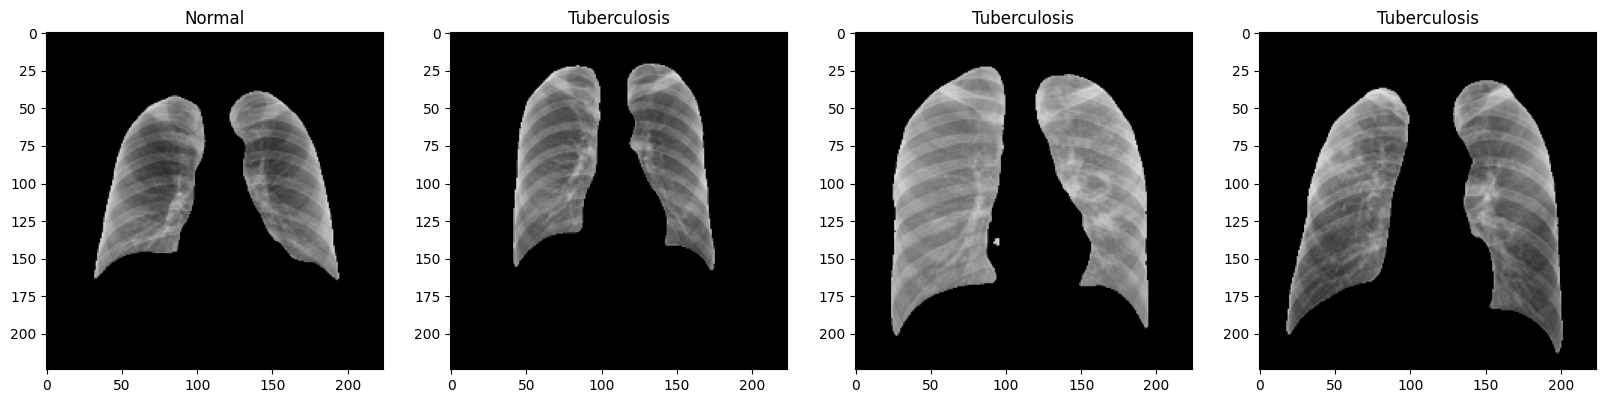

In [23]:
# Display some examples - 0 is benign and 1 is malignant
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    if batch[1][idx] == 0:
        ax[idx].title.set_text('Normal')
    else:
        ax[idx].title.set_text('Tuberculosis')


In [24]:
# Scale the data
# We standardize the pixels to range 0-1

data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [25]:
# Split the data
train_size = int(len(data)*.7)
# Used During Training
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [26]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [ ]:

from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

# Load the VGG19 model without the top layers (include_top=False)
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the VGG19 model layers weights
for layer in vgg_model.layers:
    layer.trainable = False

# Creating a new model a new model using the VGG19 model as a base
model = Sequential()
model.add(vgg_model)


# Adding  a new classifier layer on top of the base model
model.add(Flatten())
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
# model summary
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 vgg19 (Functional)          (None, 7, 7, 512)         20024384  

                                                                 

 flatten (Flatten)           (None, 25088)             0         

                                                                 

 dense (Dense)               (None, 224)               5619936   

                                                                 

 dropout (Dropout)           (None, 224)               0         

                                                                 

 dense_1 (Dense)             (None, 1)                 225       

                                                                 


Total params: 25,644,545

Trainable params: 5,620,161

Non-trainable params: 20,024,384

_________________________________________________________________


In [ ]:
# Compile the model with the desired optimizer and loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('D:/lung-segmentation-master/lung-segmentation-master/tuberculosisClassifier.h5',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

# Train the model using the data
history = model.fit(train, epochs=150, batch_size=32,validation_data=val,callbacks=[model_checkpoint])

Epoch 1/150

17/17 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9890

Epoch 1: val_accuracy improved from -inf to 0.98125, saving model to D:/lung-segmentation-master/lung-segmentation-master\tuberculosisClassifier.h5

17/17 [==============================] - 2s 131ms/step - loss: 0.0403 - accuracy: 0.9890 - val_loss: 0.0678 - val_accuracy: 0.9812

Epoch 2/150

17/17 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9890

Epoch 2: val_accuracy did not improve from 0.98125

17/17 [==============================] - 2s 101ms/step - loss: 0.0371 - accuracy: 0.9890 - val_loss: 0.0746 - val_accuracy: 0.9812

Epoch 3/150

17/17 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9890

Epoch 3: val_accuracy did not improve from 0.98125

17/17 [==============================] - 2s 107ms/step - loss: 0.0298 - accuracy: 0.9890 - val_loss: 0.0717 - val_accuracy: 0.9750

Epoch 4/150

17/17 [==============================] - ETA: 0

In [ ]:
model.save('D:/lung-segmentation-master/lung-segmentation-master/tuberculosisClassifier.h5')

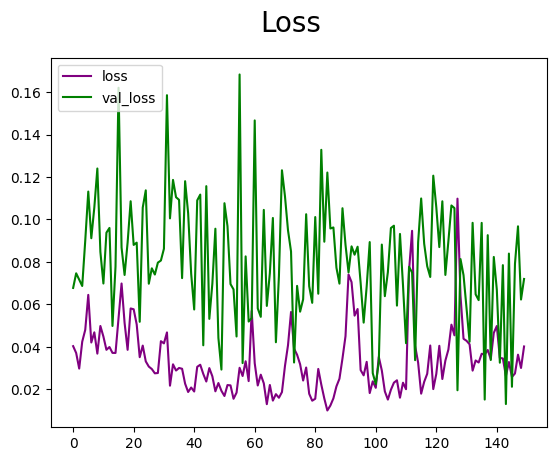

In [ ]:
# Plot Loss Graph
fig = plt.figure()
plt.plot(history.history['loss'], color='purple', label='loss')
plt.plot(history.history['val_loss'], color='green', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


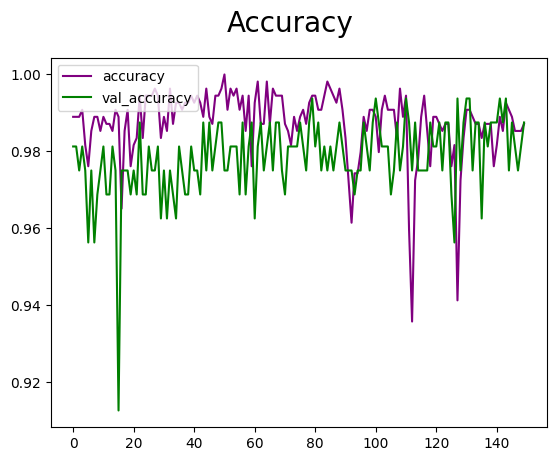

In [ ]:
# Plot Accuracy Graph
fig = plt.figure()
plt.plot(history.history['accuracy'], color='purple', label='accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [ ]:
# Model Perfomance
import pandas as pd
import numpy as np
X = []
y = []

# Load the test data
for batch in test.as_numpy_iterator():
    A, b = batch
    X.append(A)
    y.append(b)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# Predict on the entire test data
yhat = model.predict(X)

2/2 [==============================] - 1s 360ms/step


In [ ]:

# Test one of the batches

y = y.reshape((-1,))
yhat = yhat.reshape((-1,))
yhat = yhat.round()
dfNew = pd.DataFrame(data={"Actual Value": y, "Predicted Value": yhat})

pd.set_option('display.max_rows', None)
dfNew

,Actual Value,Predicted Value
0,1,1.0
1,0,0.0
2,1,1.0
3,1,1.0
4,1,1.0
5,0,0.0
6,0,0.0
7,0,0.0
8,1,1.0
9,0,1.0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y, yhat, target_names=['Normal', 'Tuberculosis'], digits=4)
print(report)

              precision    recall  f1-score   support



      Normal     1.0000    0.9714    0.9855        35

Tuberculosis     0.9667    1.0000    0.9831        29



    accuracy                         0.9844        64

   macro avg     0.9833    0.9857    0.9843        64

weighted avg     0.9849    0.9844    0.9844        64




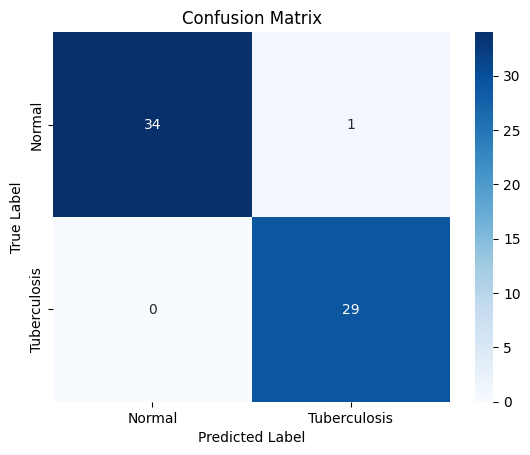

In [ ]:

# Define class labels
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(y, np.round(yhat))
class_names = ['Normal', 'Tuberculosis']

# Plot heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

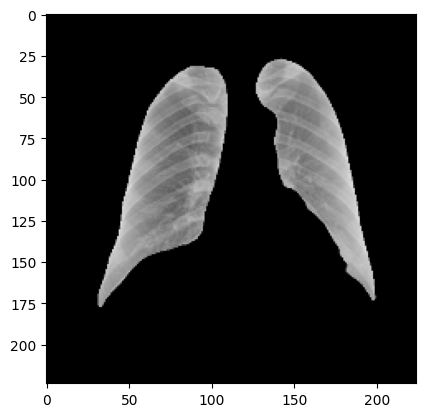

In [ ]:
# Test some images

# Normal Image with no TB
img = cv2.imread('D:/tb_dataset/Dataset_Segmented1/Normal/CHNCXR_0001_0.png')
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))

plt.show()

In [ ]:
Img_pred = model.predict(np.expand_dims(resize/255, 0))
Img_pred.item()

1/1 [==============================] - 0s 51ms/step


1.41930263453105e-06

In [ ]:
if Img_pred > 0.5:
    print('You have TUBERCULOSIS')
else:
    print('You are NORMAL (no TB)')

You are NORMAL (no TB)


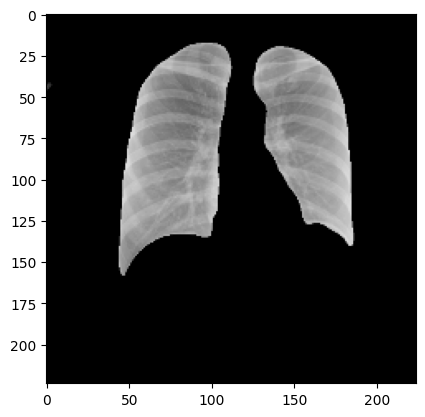

1/1 [==============================] - 0s 28ms/step

0.9642803072929382

You have TUBERCULOSIS


In [ ]:
# X-ray Image with TB
img = cv2.imread('D:/tb_dataset/Dataset_Segmented1/TB/CHNCXR_0328_1.png')
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

Img_pred = model.predict(np.expand_dims(resize/255, 0))
print(Img_pred.item())
if Img_pred > 0.5:
    print('You have TUBERCULOSIS')
else:
    print('You are NORMAL (no TB)')

# With Batch Normalization

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

def custom_VGG19(input_shape=(224, 224, 3), num_classes=1):
    # Define input layer
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Top layers
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(inputs, x, name='custom_vgg19')

    return model

# Create custom VGG19 model with batch normalization
custom_vgg19 = custom_VGG19()


In [ ]:
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

# Load the VGG19 model without the top layers (include_top=False)
vgg_model = custom_VGG19( input_shape=(224, 224, 3),weights='imagenet')
# Freezing the VGG19 model layers weights
for layer in vgg_model.layers:
    layer.trainable = False

# Creating a new model a new model using the VGG19 model as a base
model = Sequential()
model.add(vgg_model)


# Adding  a new classifier layer on top of the base model
model.add(Flatten())
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

TypeError: custom_VGG19() got an unexpected keyword argument 'weights'